In [1]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from tbcontrol.symbolic import routh
import pandas as pd

In [2]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [3]:
s  = ctl.TransferFunction.s
G  = 1/(1.59154943091895*s + 1.0)

G_bkp = G
G

TransferFunction(array([1]), array([1.59154943, 1.        ]))

polos:  (-0.628+0j)
zeros: 


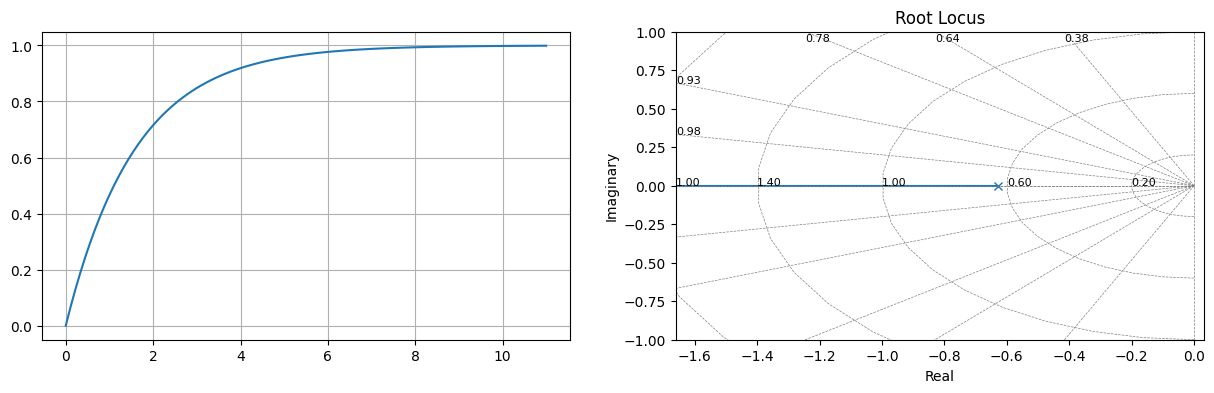

In [4]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

# REQUISITOS DO SISTEMA
- Os requisitos do sistema serão encontrados a partir do overshoot e tempo de establização máximos permitidos

In [5]:
Ts = 5.0
UP = 0.1

- $\zeta = -\frac{ln(UP\%)}{\sqrt{\pi² + ln²(UP\%)}}$

In [6]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.5911550337988976

- $\omega_n = \frac{4}{\zeta\,t_s}$ 

In [7]:
Wn = 4/(zeta*Ts)
Wn

1.3532829025560638

- $s_d = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta²}j$

In [8]:
s_d = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_d = roundSympyFunction(s_d, 3)

s_d

-0.8 + 1.092*I

In [9]:
f_c = 0.1
w_c = 2*np.pi*f_c

f_c, w_c

(0.1, 0.6283185307179586)

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K\frac{s-a}{s-b}$

In [10]:
G = sympyFunction(G)
G

1/(1.59154943091895*s + 1.0)

In [11]:
angle = sp.arg(G.subs(s, s_d))
angle = float(angle)
angle

-1.7267816396301847

In [12]:
phi = angle - np.pi
phi

-4.868374293219977

- O zero localizado em $a$ corta com o polo mais estável do sistema, se não tiver, deve-se cortar com o polo do $s$ desejado

In [13]:
a = np.real(poles[0])
a = float(a)
a

-0.62831853071796

In [14]:
b = sp.re(s_d) + sp.im(s_d)*np.tan(3/2*phi)
b = float(b)
b

-2.5754748600233124

In [15]:
G_ma = G * (s - a)/(s - b)

K = 1/sp.Abs(G_ma.subs(s, s_d))
K = roundSympyFunction(sp.N(K))
K = float(K)
K

3.3173699975013733

# RESPOSTA CONTROLADA

In [16]:
s  = ctl.TransferFunction.s

C = K * (s - a)/(s * (s - b))
G = G_bkp

G_ma = G*C
G_ma

TransferFunction(array([3.31737   , 2.08436504]), array([1.59154943, 5.09899555, 2.57547486, 0.        ]))

In [17]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([3.31737   , 2.08436504]), array([1.59154943, 5.09899555, 5.89284486, 2.08436504]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

In [18]:
[np.round(val, 3) for val in list(ctl.poles(G_feedback))]

[(-1.288+0.653j), (-1.288-0.653j), (-0.628+0j)]

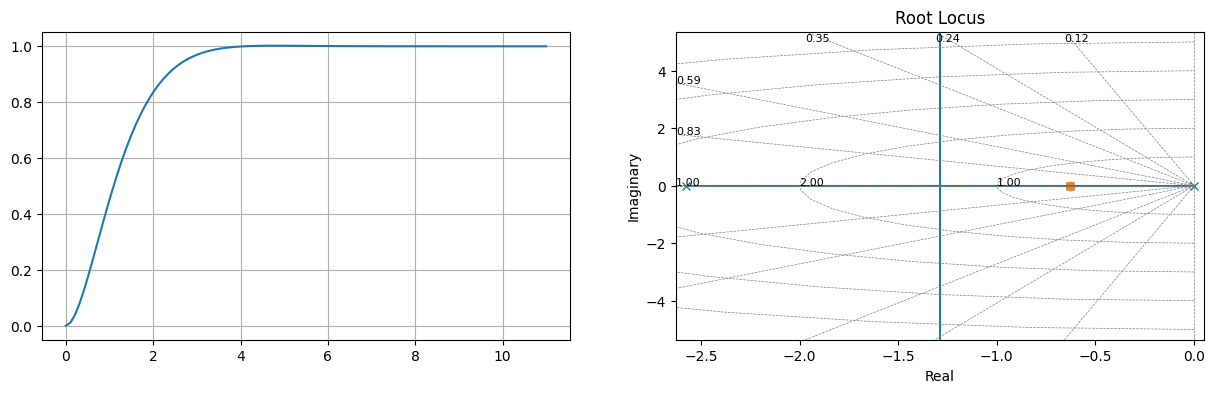

In [19]:
time, response = ctl.step_response(G_feedback)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [20]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.0020356746772409824
valor de pico:  1.002034134298442
tempo de pico:  4.803218730520507
tempo de assentamento:  3.2021458203470052
valor final:  0.9999984627505408
erro:  1.5372494591714414e-06


# APLICANDO VÁRIOS STEPS

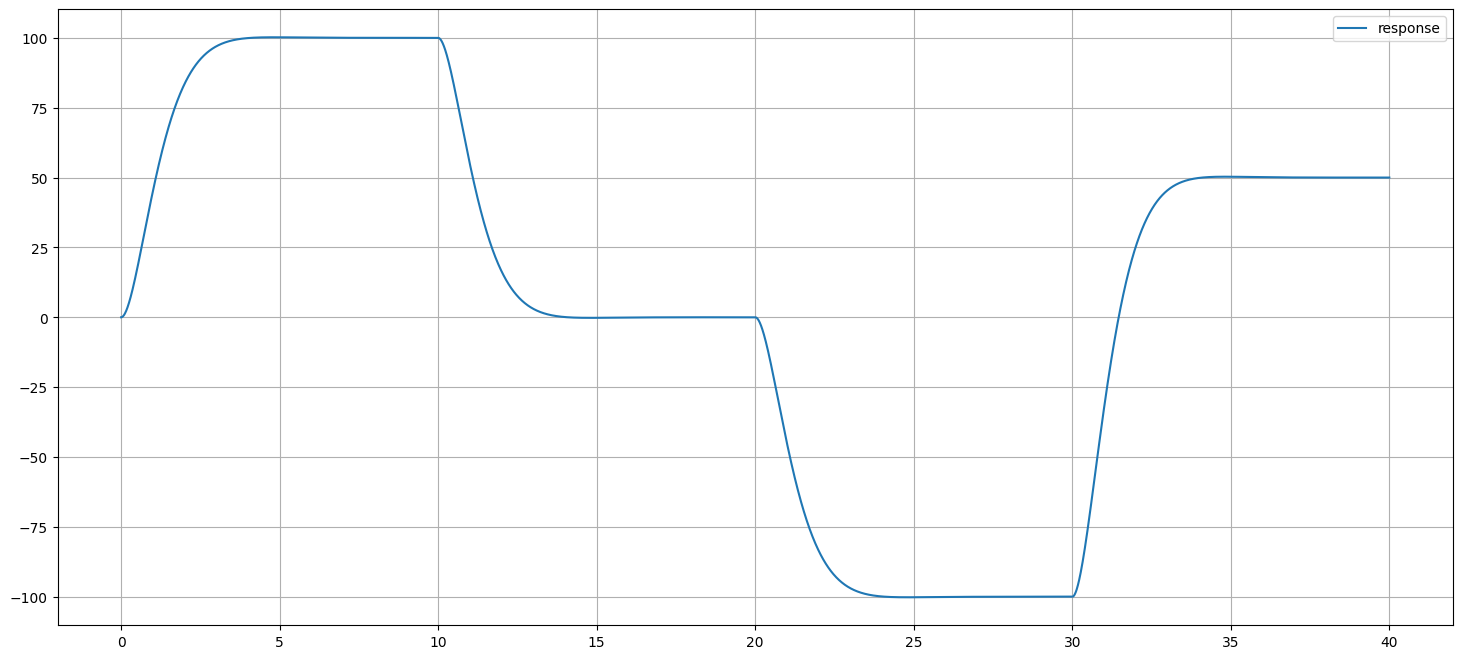

In [21]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()

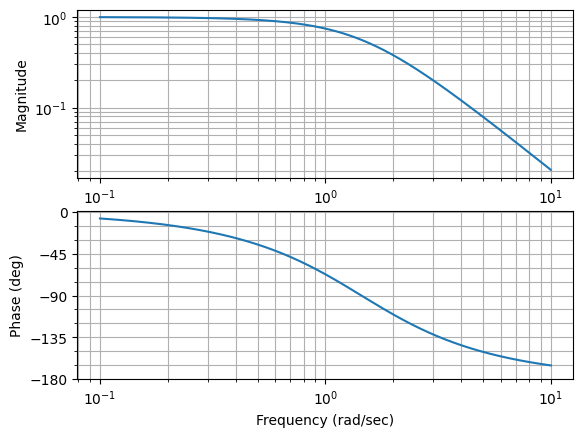

In [22]:
mag, fase, omega = ctl.bode(G_feedback, plot=True)

In [23]:
1/2**0.5

0.7071067811865475

In [24]:
df = pd.DataFrame({'mag': mag, 'fase': fase, 'omega': w_c})
df['difference'] = abs(df['omega'] - w_c)
df

,mag,fase,omega,difference
0,0.997164,-0.123525,0.628319,0.0
1,0.997138,-0.124096,0.628319,0.0
2,0.997112,-0.124669,0.628319,0.0
3,0.997085,-0.125244,0.628319,0.0
4,0.997058,-0.125823,0.628319,0.0
...,...,...,...,...
995,0.021351,-2.879616,0.628319,0.0
996,0.021157,-2.880817,0.628319,0.0
997,0.020965,-2.882013,0.628319,0.0
998,0.020775,-2.883204,0.628319,0.0


In [25]:
df.loc[df['difference'] == df['difference'].min()].mean()

mag           0.602538
fase         -1.349502
omega         0.628319
difference    0.000000
dtype: float64